<a href="https://colab.research.google.com/github/Mayankkestwal10/fast-ai/blob/master/Planet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Multi-label Prediction with Planet Amazon dataset</h2>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mayankkestwal10","key":"ea056eabd75cacd9ff061ba1d9cec00b"}'}

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space

100% 598M/600M [00:08<00:00, 78.1MB/s]
100% 600M/600M [00:08<00:00, 70.1MB/s]
 99% 599M/603M [00:05<00:00, 120MB/s]
100% 603M/603M [00:05<00:00, 107MB/s]
100% 12.9G/12.9G [03:41<00:00, 48.9MB/s]
100% 12.9G/12.9G [03:41<00:00, 62.3MB/s]
100% 19.4G/19.4G [05:45<00:00, 70.5MB/s]
100% 19.4G/19.4G [05:45<00:00, 60.5MB/s]
 94% 286M/304M [00:01<00:00, 159MB/s]
100% 304M/304M [00:01<00:00, 179MB/s]
  0% 0.00/1.52M [00:00<?, ?B/s]
100% 1.52M/1.52M [00:00<00:00, 203MB/s]
  0% 0.00/1.01M [00:00<?, ?B/s]
100% 1.01M/1.01M [00:00<00:00, 139MB/s]
  0% 0.00/154k [00:00<?, ?B/s]
100% 154k/154k [00:00<00:00, 160MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 164MB/s]
  0% 0.00/110k [00:00<?, ?B/s]
100% 110k/110k [00:00<00:00, 94.1MB/s]


In [0]:
!7za x train-jpg.tar.7z
!tar -xvf train-jpg.tar


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 629296207 bytes (601 MiB)

Extracting archive: train-jpg.tar.7z
--
Path = train-jpg.tar.7z
Type = 7z
Physical Size = 629296207
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - train-jpg.tar                      1% - train-jpg.tar                      2% - train-jpg.tar                      3% - train-jpg.tar                      4% - train-jpg.tar                      5% - train-jpg.tar                      6% - train-jpg.tar

<h2>Multiclassification</h2>

In [0]:
df = pd.read_csv('train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True,max_lighting=0.1,max_zoom=1.05,max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path='/content/',csv_name='train_v2.csv',folder='train-jpg',suffix='.jpg')
       .split_by_rand_pct(0.2).label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128).databunch().normalize(imagenet_stats))

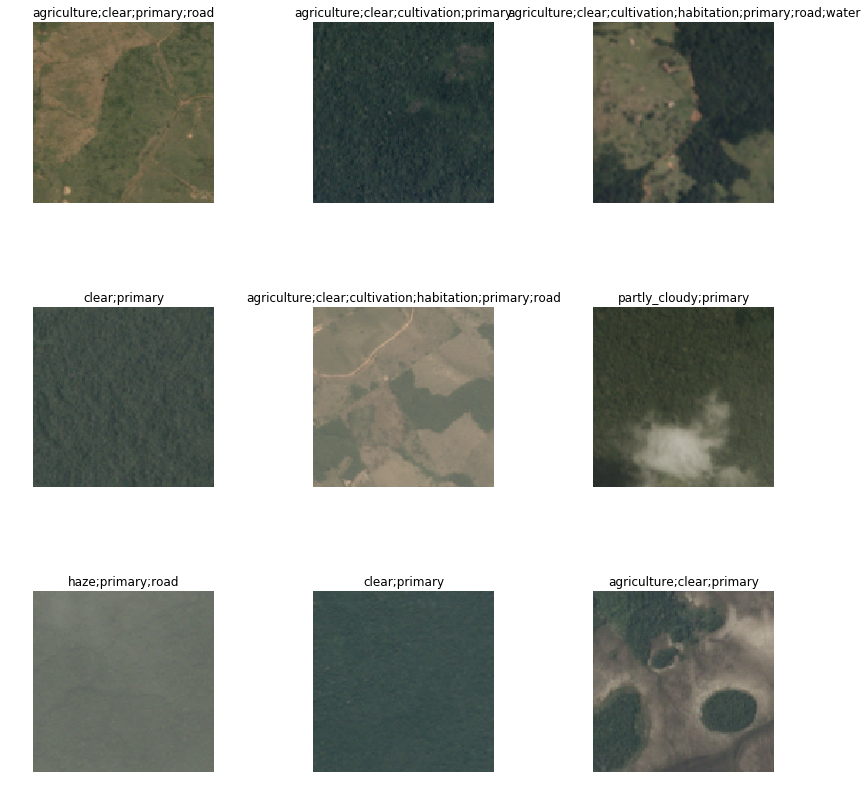

In [0]:
data.show_batch(rows=3, fig_size=(5,5))

<p>To create a Learner we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use accuracy_thresh instead of accuracy. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. accuracy_thresh selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition.</p>

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh,thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02,f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 147516047.29it/s]


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


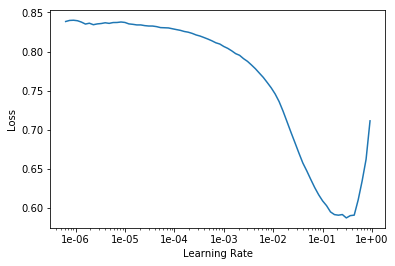

In [0]:
learn.recorder.plot()

In [0]:
lr=0.01

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.126784,0.109653,0.945820,0.904453,02:28
1,0.106329,0.099390,0.953530,0.913001,02:26
2,0.100357,0.091106,0.949606,0.920913,02:26
3,0.094572,0.087794,0.955637,0.924212,02:26
4,0.088333,0.087144,0.955702,0.924065,02:26


In [0]:
learn.save('stage-1-resnet50')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


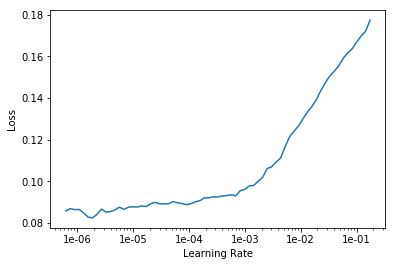

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097517,0.093711,0.952832,0.914277,02:35
1,0.096626,0.090020,0.956349,0.924436,02:35
2,0.091061,0.086075,0.957069,0.927062,02:36
3,0.085006,0.083362,0.957824,0.927442,02:36
4,0.079618,0.082538,0.959394,0.929452,02:35


In [0]:
learn.save('stage-2-resnet50')

In [0]:
data = (src.transform(tfms,size=256)
       .databunch().normalize(imagenet_stats))
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


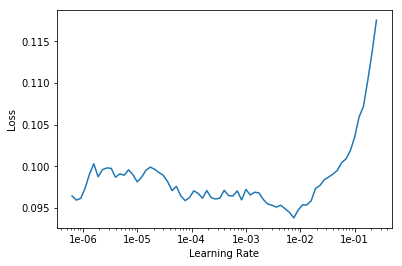

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2/2

In [0]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086788,0.084214,0.956189,0.927480,05:09
1,0.089752,0.084658,0.957403,0.927652,05:12
2,0.084622,0.083034,0.959089,0.928868,05:12
3,0.083062,0.081281,0.959088,0.930858,05:12
4,0.082337,0.081135,0.958812,0.930021,05:11


In [0]:
learn.save('stage-1-256-resnet50')

In [0]:
learn.unfreeze()

In [31]:
learn.fit_one_cycle(5,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084623,0.083752,0.956996,0.927963,06:54
1,0.085629,0.085714,0.955877,0.926987,07:01
2,0.079990,0.082920,0.960695,0.929153,07:00
3,0.081600,0.080844,0.958922,0.930569,07:01
4,0.075931,0.080740,0.960273,0.930501,07:00


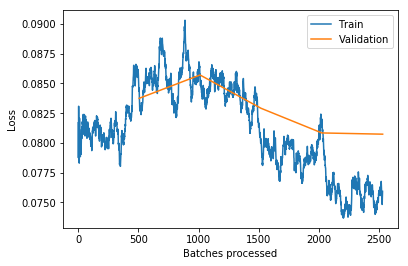

In [33]:
learn.recorder.plot_losses()

In [0]:
learn.save("stage-2-256-resnet50")

In [0]:
learn.export('planet.pkl')

In [41]:
!7za x test-jpg.tar.7z
!tar -xvf test-jpg.tar


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 632362315 bytes (604 MiB)

Extracting archive: test-jpg.tar.7z
--
Path = test-jpg.tar.7z
Type = 7z
Physical Size = 632362315
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - test-jpg.tar                     1% - test-jpg.tar                     2% - test-jpg.tar                     3% - test-jpg.tar                     4% - test-jpg.tar                     5% - test-jpg.tar                     6% - test-jpg.tar                   

In [0]:
test = ImageList.from_folder(path='/content/test-jpg').add(ImageList.from_folder(path='/content/test-jpg-additional'))

In [43]:
len(test)

61191

In [0]:
learn = load_learner(file='planet.pkl',path='/content/', test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_pred = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p>thresh]) for pred in preds]

In [59]:
labelled_pred[:5]

['agriculture clear haze primary water',
 'partly_cloudy primary',
 'agriculture clear cultivation habitation primary water',
 'haze partly_cloudy primary',
 'clear partly_cloudy primary']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_pred}, columns=['image_name', 'tags'])

In [0]:
df.to_csv('submission.csv',index=False)

In [67]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {'/content/submission.csv'} -m "submission"

100% 2.19M/2.19M [00:06<00:00, 371kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space